# Valvestate simulation

[Schematics](https://drtube.com/schematics/marshall/pc0689.pdf)

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import csv
import sympy
import re

In [2]:
# Sample rate to use when plotting digital filter responses
rate = 96000
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams['axes.grid'] = True

from sympy.abc import s, z, K

# Filters

Analog filters are discretectised using the method described in [DISCRETIZATION OF THE ’59 FENDER BASSMAN TONE STACK by David T. Yeh, Julius O. Smith](https://ccrma.stanford.edu/~dtyeh/papers/yeh06_dafx.pdf).

In summary, symbolic analysis is performed on the schematic in the s-domain, the the bilinear transform is used to genereate a z-domain transfer function, which can be implemented as an IIR filter.

They gloss over how exactly to perform the symbolic circuit analysis. I have used QSapecNG for this. This software performs symbolic analysis on a graphical schematic, so it is quite easy to use. Schematics are available for each circuit under the file mentioned in the relevant code snippet.

Lcapy, MATLAB SCAM, Wolfram SystemModeler could possibly work here. I have only tried lcapy, and altough it would be nice to do all the work inside Python, it was too slow to be usable.

In [3]:
def print_as_cpp_coefficients(coeffs, name):
    for i in range(len(coeffs)):    
        tmp = f"float {name}{i} = {coeffs[i]};"
        # substitute python power syntax a**2 to std::pow(a, 2)
        print(re.sub(r"([a-zA-Z])\*\*(\d)", r"std::pow(\1, \2)", tmp))
    
print_as_cpp_coefficients(range(0, 3), "test")
print_as_cpp_coefficients([s**5, 2], "power")

float test0 = 0;
float test1 = 1;
float test2 = 2;
float power0 = std::pow(s, 5);
float power1 = 2;


Helper function to perform bilinear transform by substituting $s$ for $K\frac{1-z^{-1}}{1+z^{-1}}$.

In [13]:
def bilinear_transform(tf_s):
    s_sub = K*(1-z**-1)/(1+z**-1)
    tf_z = tf_s.subs(s, s_sub).normal().simplify().factor()
    n, d = sympy.fraction(tf_z)
    n_frac = sympy.poly(n, z)
    d_frac = sympy.poly(d, z)
    B = n_frac.all_coeffs()
    A = d_frac.all_coeffs()
    return B, A

b0, b1, b2, a0, a1, a2 = sympy.symbols("b0, b1, b2, a0, a1, a2")

# this should print the general bilinear transform for a biquad
bilinear_transform((b0 + b1 * s**-1 + b2 * s**-2)/(a0 + a1 * s**-1 + a2 * s**-2))

([K**2*b0 + K*b1 + b2, -2*K**2*b0 + 2*b2, K**2*b0 - K*b1 + b2],
 [K**2*a0 + K*a1 + a2, -2*K**2*a0 + 2*a2, K**2*a0 - K*a1 + a2])

In [14]:
def plot_frequency_response(B, A, rate=44100, k=2*rate):
    b = []
    a = []
    for i in range(len(B)):
        b.append(float(B[i].subs(K, k)))
        a.append(float(A[i].subs(K, k)))

    f = signal.dlti(b, a)
    w, H = signal.dfreqresp(f)

    plt.figure()
    plt.semilogx(w/2/np.pi*rate, 20*np.log10(np.abs(H)))
    plt.title("Input filter frequency response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.show()

## Input filter

This is the first stage of the amplifier, it's suspiciously similar to a tubescreamer pedal.

In [15]:
# TODO recreate this schematic, seems it was not saved properly

float B0 = 1.10449884469421e-9*std::pow(K, 2) + 0.00246545127613797*K + 0.5;
float B1 = 1.0 - 2.20899768938842e-9*std::pow(K, 2);
float B2 = 1.10449884469421e-9*std::pow(K, 2) - 0.00246545127613797*K + 0.5;
float A0 = 1.10449884469421e-9*std::pow(K, 2) + 0.000115449950739352*K + 0.5;
float A1 = 1.0 - 2.20899768938842e-9*std::pow(K, 2);
float A2 = 1.10449884469421e-9*std::pow(K, 2) - 0.000115449950739352*K + 0.5;


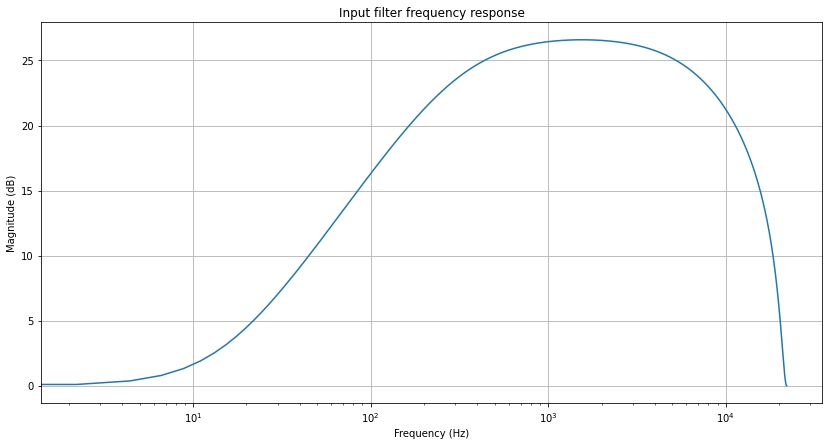

In [16]:
#input_filter.info
s, z, K = sympy.symbols("s z K")
tf_s = (s**2 + 2.23219e+06*s + 4.52694e+08)/(1 * s**2 + 104527*s + 4.52694e+08)

B, A = bilinear_transform(tf_s)

print_as_cpp_coefficients(B, "B")
print_as_cpp_coefficients(A, "A")

plot_frequency_response(B, A)

## Gain control

No QSapecNG schematic here, this one was done by hand! There are two sets of functions, as this circuit has two switchable modes (OD1/OD2).

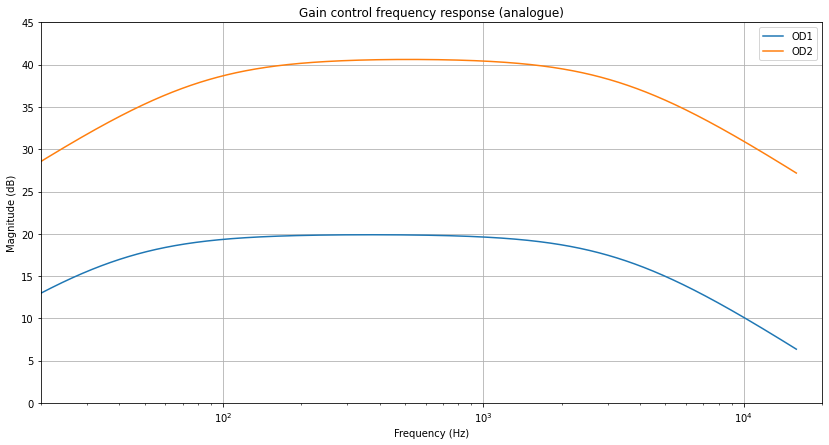

In [38]:
C1 = 220e-9
C2 = 47e-12
R1 = 22e3
R2 = 100e3
Rg = sympy.symbols("Rg")
Rg_value = 1e6

B1 = [R1*Rg*C1, sympy.Integer(0)]
A1 = [R1*R2*Rg*C1*C2, R1*R2*C1 + R1*Rg*C2 + R2*Rg*C2, sympy.Rational(R1+R2)]

B2 = [Rg*C1, sympy.Integer(0)]
R1 = 9.09e3
A2 = [R1*Rg*C1*C2, R1*C1 + Rg*C2, sympy.Integer(1)]

B1_sub = [float(exp.subs(Rg, Rg_value)) for exp in B1]
A1_sub = [float(exp.subs(Rg, Rg_value)) for exp in A1]
B2_sub = [float(exp.subs(Rg, Rg_value)) for exp in B2]
A2_sub = [float(exp.subs(Rg, Rg_value)) for exp in A2]

f1 = signal.lti(B1_sub, A1_sub)
f2 = signal.lti(B2_sub, A2_sub)
w1, H1 = signal.freqresp(f1)
w2, H2 = signal.freqresp(f2)

plt.figure()
plt.semilogx(w1/2/np.pi, 20*np.log10(np.abs(H1)), label="OD1")
plt.semilogx(w2/2/np.pi, 20*np.log10(np.abs(H2)), label="OD2")
plt.title("Gain control frequency response (analogue)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(20, 20e3)
plt.ylim(0, 45)
plt.legend()
plt.show()

In [39]:
g = sympy.symbols("g")

tf1_s = ((B1[0]*s)/(A1[0]*s**2 + A1[1]*s + A1[2])).subs(Rg, Rg_value*g)
tf2_s = ((B2[0]*s)/(A2[0]*s**2 + A2[1]*s + A2[2])).subs(Rg, Rg_value*g)

B1z, A1z = bilinear_transform(tf1_s)
B2z, A2z = bilinear_transform(tf2_s)

print_as_cpp_coefficients(B1z, "B1")
print_as_cpp_coefficients(A1z, "A1")
print_as_cpp_coefficients(B2z, "B2")
print_as_cpp_coefficients(A2z, "A2")

float B10 = 0.0198360655737705*K*g;
float B11 = 0;
float B12 = -0.0198360655737705*K*g;
float A10 = 9.32295081967213e-8*std::pow(K, 2)*g + 2.35e-5*K*g + 0.00198360655737705*K + 0.5;
float A11 = -1.86459016393443e-7*std::pow(K, 2)*g + 1.0;
float A12 = 9.32295081967213e-8*std::pow(K, 2)*g - 2.35e-5*K*g - 0.00198360655737705*K + 0.5;
float B20 = 0.11*K*g;
float B21 = 0;
float B22 = -0.11*K*g;
float A20 = 4.69953e-8*std::pow(K, 2)*g + 2.35e-5*K*g + 0.0009999*K + 0.5;
float A21 = -9.39906e-8*std::pow(K, 2)*g + 1.0;
float A22 = 4.69953e-8*std::pow(K, 2)*g - 2.35e-5*K*g - 0.0009999*K + 0.5;


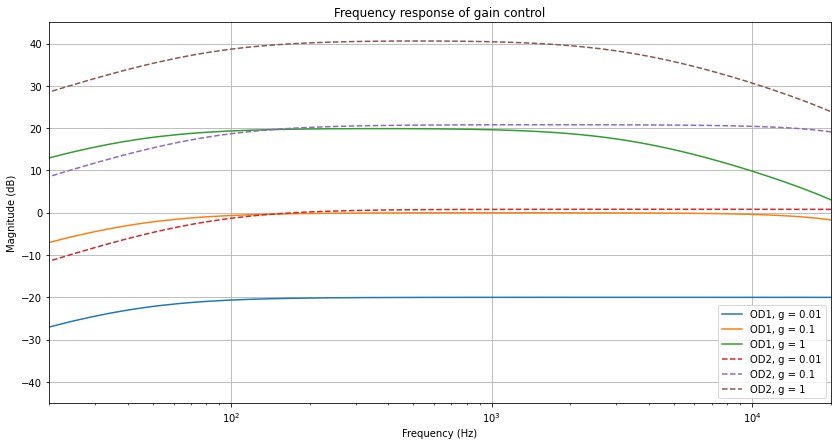

In [40]:
G = [0.01, 0.1, 1]
k = 2*rate

plt.figure()
for B, A, label, linestyle in [[B1z, A1z, "OD1", "-"], [B2z, A2z, "OD2", "--"]]:
        
    for gg in G:
        b = [float(BB.subs(K, k).subs(g, gg)) for BB in B]
        a = [float(AA.subs(K, k).subs(g, gg)) for AA in A]
            
        f = signal.dlti(b, a)
        w, H = signal.dfreqresp(f)
        
        # ignore divide by 0 errors
        with np.errstate(divide='ignore'):
            plt.semilogx(w/2/np.pi*rate, 20*np.log10(np.abs(H)), label=f"{label}, g = {gg}", linestyle=linestyle)

plt.legend()
plt.title("Frequency response of gain control")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(20, 20e3)
plt.ylim(-45, 45)
plt.show()

## Contour filter

In [60]:
Rp1, Rp2, V1, s, p = sympy.symbols("Rp1 Rp2 V1 s p")
R1 = 4.7e3
R2 = 33e3
R3 = 47e3
R4 = 100e3
Rp = 100e3
C1 = 1e-9
C2 = 47e-9
C3 = 22e-9
C4 = 10e-9

exp = ((( 1.0032e-14 * Rp1 * Rp2 * V1 + 1.94495e-10 * Rp1 * V1 ) * s**3 +
       ( 1.254e-10 * Rp1 * Rp2 * V1 + 4.56e-07 * Rp1 * V1 + 1.76e-07 * Rp2 * V1 + 0.0034122 * V1 ) * s**2 +
       ( 0.0057 * Rp1 * V1 + 0.0022 * Rp2 * V1 + 8 * V1 ) * s + 100000 * V1) / 
       (( 3.88784e-19 * Rp1 * Rp2 + 7.53755e-15 * Rp1 ) * s**4 +
        ( 1.92511e-14 * Rp1 * Rp2 + 5.04208e-10 * Rp1 + 3.88784e-11 * Rp2 + 7.53755e-07 ) * s**3 + 
        ( 2.31614e-10 * Rp1 * Rp2 + 7.82459e-06 * Rp1 + 1.05904e-06 * Rp2 + 0.0297419 ) * s**2 +
        ( 0.0105279 * Rp1 + 0.0040634 * Rp2 + 170.06 ) * s + 184700))

exp_final = exp.subs(Rp1, Rp*p).subs(Rp2, Rp*(1-p)).subs(V1, 1)
n, d = sympy.fraction(exp_final)
n_poly = sympy.Poly(n,s)
d_poly = sympy.Poly(d,s)
B = n_poly.all_coeffs()
A = d_poly.all_coeffs()

/usr/lib/python3.9/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


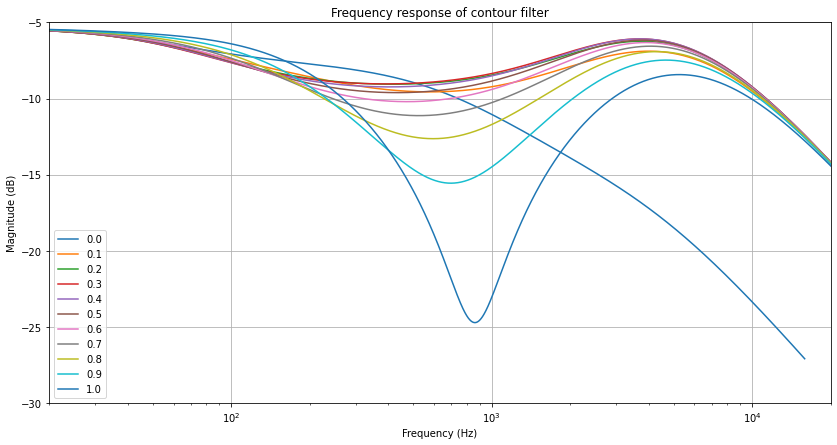

In [61]:
P = np.linspace(0, 1, 11)
for pp in P:
    b = [float(BB.subs(p, pp)) for BB in B]
    a = [float(AA.subs(p, pp)) for AA in A]
            
    tf = signal.lti(b, a)
    w, H = signal.freqresp(tf)
    plt.semilogx(w/2/np.pi, 20*np.log10(np.abs(H)), label=f"{pp:.1f}")

plt.title("Frequency response of contour filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(20, 20e3)
plt.ylim(-30, -5)
plt.legend()
plt.show()

In [62]:
#bilinear transform
s, z, K = sympy.symbols("s z K")

tf = (B[0]*s**3 + B[1]*s**2 + B[2]*s + B[3])/(A[0]*s**4 + A[1]*s**3 + A[2]*s**2 + A[3]*s + A[4])
Bz, Az = bilinear_transform(tf)
print_as_cpp_coefficients(Bz, "B")
print_as_cpp_coefficients(Az, "A")

float B0 = 9.05251759610179e-11*std::pow(K, 3)*std::pow(p, 2) - 1.08075708355892e-10*std::pow(K, 3)*p + 1.13156469951272e-6*std::pow(K, 2)*std::pow(p, 2) - 1.15683089695001e-6*std::pow(K, 2)*p - 1.89606569211334e-8*std::pow(K, 2) - 0.000315827467966071*K*p - 0.000205739036275041*K - 0.0902364194188775;
float B1 = -1.81050351922036e-10*std::pow(K, 3)*std::pow(p, 2) + 2.16151416711785e-10*std::pow(K, 3)*p - 0.000631654935932142*K*p - 0.000411478072550081*K - 0.36094567767551;
float B2 = -2.26312939902545e-6*std::pow(K, 2)*std::pow(p, 2) + 2.31366179390002e-6*std::pow(K, 2)*p + 3.79213138422667e-8*std::pow(K, 2) - 0.541418516513265;
float B3 = 1.81050351922036e-10*std::pow(K, 3)*std::pow(p, 2) - 2.16151416711785e-10*std::pow(K, 3)*p + 0.000631654935932142*K*p + 0.000411478072550081*K - 0.36094567767551;
float B4 = -9.05251759610179e-11*std::pow(K, 3)*std::pow(p, 2) + 1.08075708355892e-10*std::pow(K, 3)*p + 1.13156469951272e-6*std::pow(K, 2)*std::pow(p, 2) - 1.15683089695001e-6*std::pow(K,

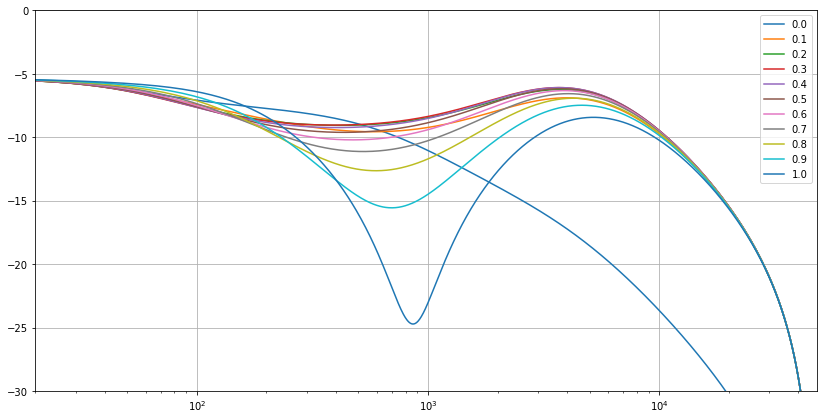

In [66]:
tf = []
P = np.linspace(0, 1, 11)
k = 2*rate

for pp in P:
    b = []
    a = []
    for i in range(len(Bz)):
        b.append(float(Bz[i].subs(p, pp).subs(K, k)))
        a.append(float(Az[i].subs(p, pp).subs(K, k)))

    tf = signal.dlti(b, a)
    w, H = signal.dfreqresp(tf)
    plt.semilogx(w/2/np.pi*rate, 20*np.log10(np.abs(H)), label=f"{pp:0.1f}")
plt.legend()
plt.ylim(-30, 0)
plt.xlim(20, rate/2)
plt.show()